# Practice: REINFORCE in PyTorch
__This notebook is based on [Practical_RL week06](https://github.com/yandexdataschool/Practical_RL/tree/master/week06_policy_based) materials__

Just like we did before for q-learning, this time we'll design a pytorch network to learn `CartPole-v0` via policy gradient (REINFORCE).

Most of the code in this notebook is taken from approximate qlearning, so you'll find it more or less familiar and even simpler.

In [1]:
import os
import sys


if "google.colab" in sys.modules and not os.path.exists(".setup_complete"):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ["DISPLAY"] = ":1"

Selecting previously unselected package xvfb.
(Reading database ... 155676 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.11_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.11) ...
Setting up xvfb (2:1.19.6-1ubuntu4.11) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Starting virtual X frame buffer: Xvfb.


In [3]:
!pip install gym[classic_control]==0.19.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 8.8 MB/s 
     |████████████████████████████████| 1.1 MB 46.9 MB/s 
  Created wheel for gym: filename=gym-0.19.0-py3-none-any.whl size=1663118 sha256=ff5740b87226fcfc039154b2b66ef4f2fb93b7db97ccb10c20977100dc6e74e3
  Stored in directory: /root/.cache/pip/wheels/ef/9d/70/8bea53f7edec2fdb4f98d9d64ac9f11aea95dfcb98099d7712
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.1
    Uninstalling gym-0.25.1:
      Successfully uninstalled gym-0.25.1


C:\Anaconda\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Изменение режима для потока после его установки невозможно
  warnings.warn(str(err))


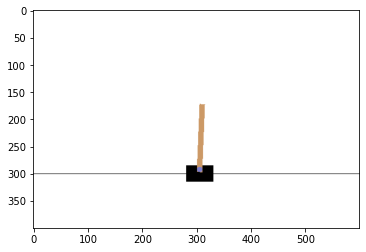

In [1]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


%matplotlib inline

env = gym.make("CartPole-v1").env
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

plt.imshow(env.render("rgb_array"));

In [2]:
env.close()

## Building the network for REINFORCE

For REINFORCE algorithm, we'll need a model that predicts action probabilities given states. Let's define such a model below.

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# YOUR CODE HERE
# Build a simple neural network that predicts policy logits.
# Hint: keep it simple. CartPole isn't worth deep architectures.
model = nn.Sequential(
    nn.Linear(state_dim, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, n_actions)
)

## Predict function

Let's define function which will take states as input and return probabilities for actions.

> Note: input and output of this function are not a torch tensors, they're numpy arrays.

In [4]:
def predict_probs(state):
    # Predict action probabilities given current state.
    # Note: state is a numpy array of shape [state_dim]
    # and return value should be a numpy array of shape [n_actions]

    softmax = nn.Softmax(dim=-1)

    logits = model(torch.FloatTensor(state)).detach()

    probs = softmax(logits)

    return probs.cpu().numpy()

In [5]:
for _ in range(5):
    test_state = env.reset()
    test_probs = predict_probs(test_state)
    assert isinstance(
        test_probs, np.ndarray
    ), f"you must return np array and not {type(test_probs)}"
    assert tuple(test_probs.shape) == (n_actions,), f"wrong output shape: {test_probs.shape}"
    assert np.isclose(test_probs.sum(), 1), "probabilities do not sum to 1"

## Play the game

We can now use our newly built agent to play the game.

In [6]:
def generate_session(env, time_limit=1000, render=False):
    states, actions, rewards = [], [], []
    state = env.reset()

    if render:
        env.render()

    for _ in range(time_limit):
        action_probs = predict_probs(state)

        # YOUR CODE HERE
        # Sample action with given probabilities.
        action = np.random.choice(np.arange(n_actions), p=action_probs)

        new_state, reward, done, _ = env.step(action)

        # record session history to train later.
        states.append(state)
        actions.append(action)
        rewards.append(reward)

        state = new_state
        if done:
            break

    env.close()

    # Convert to numpy for faster to torch transformations.
    return np.array(states), np.array(actions), np.array(rewards)

In [7]:
# test it
states, actions, rewards = generate_session(env)

## Computing cumulative rewards

Now that we have our session's rewards, let's compute cumulative rewards for actions:

$$ G_t = r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + \ldots = r_t + \gamma G_{t+1} $$

In [8]:
def get_cumulative_rewards(rewards, gamma=0.99):
    # YOUR CODE HERE
    """
    Take a list of rewards for the whole session and compute cumulative rewards.
    
    The simplest way would be to iterate from last reward to first and 

    compute G_t = r_t + gamma * G_{t+1} recurrently.

    You must return an array/list of cumulative rewards with as many elements as in the initial rewards.
    """
    G = np.zeros(len(rewards))
    G[-1] = rewards[-1]

    for idx in range(-2, -len(rewards)-1, -1):
        G[idx] = rewards[idx] + gamma * G[idx+1]

    return G

In [9]:
assert isinstance(get_cumulative_rewards(rewards), np.ndarray)
assert len(get_cumulative_rewards(list(range(100)))) == 100
assert np.allclose(
    get_cumulative_rewards([0, 0, 1, 0, 0, 1, 0], gamma=0.9),
    [1.40049, 1.5561, 1.729, 0.81, 0.9, 1.0, 0.0],
)
assert np.allclose(
    get_cumulative_rewards([0, 0, 1, -2, 3, -4, 0], gamma=0.5),
    [0.0625, 0.125, 0.25, -1.5, 1.0, -4.0, 0.0],
)
assert np.allclose(get_cumulative_rewards([0, 0, 1, 2, 3, 4, 0], gamma=0), [0, 0, 1, 2, 3, 4, 0])

## Loss function and updates

We now need to define objective and update over policy gradient.

Our objective function is

$$ J \approx  { 1 \over N } \sum_{s_i,a_i} G(s_i,a_i) $$

REINFORCE defines a way to compute the gradient of the expected reward with respect to policy parameters. The formula is as follows:

$$ \nabla_\theta \hat J(\theta) \approx { 1 \over N } \sum_{s_i, a_i} \nabla_\theta \log \pi_\theta (a_i \mid s_i) \cdot G_t(s_i, a_i) $$

Which means that we can abuse PyTorch's capabilities for automatic differentiation by defining our objective function as follows:

$$ \hat J(\theta) \approx { 1 \over N } \sum_{s_i, a_i} \log \pi_\theta (a_i \mid s_i) \cdot G_t(s_i, a_i) $$

When you compute the gradient of that function with respect to network weights $\theta$, it will become exactly the policy gradient.

In [10]:
optimizer = torch.optim.Adam(model.parameters(), 1e-3, )


def train_on_session(states, actions, rewards, gamma=0.99, entropy_coef=1e-2):
    states = torch.tensor(states, dtype=torch.float32)  # shape: [batch_size, state_dim]
    actions = torch.tensor(actions, dtype=torch.long)  # shape: [batch_size]
    # cumulative_returns = np.array(get_cumulative_rewards(rewards, gamma))
    # cumulative_returns = torch.tensor(cumulative_returns, dtype=torch.float32)  # shape: [batch_size]
    cumulative_returns = torch.tensor(
        get_cumulative_rewards(rewards, gamma), dtype=torch.float32
    )  # shape: [batch_size]

    # Predict probas and log-probas using an agent.
    logits = model(states)
    probs = torch.softmax(logits, dim=1)
    log_probs = torch.log_softmax(logits, dim=1)

    # Select log-probabilities for chosen actions, log pi(a_i|s_i)
    log_probs_for_actions = log_probs[range(states.shape[0]), actions]

    
    entropy = -torch.mean(torch.sum(probs * log_probs, dim=1))
    loss = -torch.mean(log_probs_for_actions * (cumulative_returns - cumulative_returns.mean())) - entropy * entropy_coef

    # Gradient descent step.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Return session rewards to print them later.
    return rewards.sum()

### The actual training

In [11]:
for i in range(100):
    rewards = [train_on_session(*generate_session(env)) for _ in range(100)]
    mean_reward = np.mean(rewards)
    print(f"mean reward: {mean_reward:.1f}")
    if mean_reward > 500:
        print("You Win!")
        break

mean reward: 33.8
mean reward: 94.9
mean reward: 296.9
mean reward: 599.5
You Win!


### Video

In [10]:
# Record sessions
import gym.wrappers


with gym.wrappers.Monitor(gym.make("CartPole-v1"), directory="videos", force=True) as env_monitor:
    sessions = [generate_session(env_monitor, 100000) for _ in range(100)]

In [13]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from base64 import b64encode
from pathlib import Path

from IPython.display import HTML


video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]  # You can also try other indices

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML(
    """
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(
        data_url
    )
)

## Bonus area: solving Acrobot-v1

Try to solve more complex environment using Policy gradient method.
*Hint: you will need add some imporovements to the original REINFORCE (e.g. Advantage Actor Critic or anything else).*

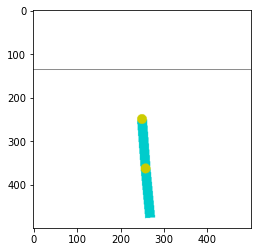

In [118]:
env = gym.make("Acrobot-v1")
env.reset()

plt.imshow(env.render("rgb_array"))
state_dim = env.reset().shape[0]
n_actions = env.action_space.n

In [119]:
env.close()

In [120]:
state_dim, n_actions

(6, 3)

## Own Actor Critic

In [121]:
class A2C(nn.Module):
    def __init__(self, state_dim, num_actions):
        super(A2C, self).__init__()
        
        self.num_actions = num_actions
        self.state_dim = state_dim
        
        self.critic_linear = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        
        self.actor_linear = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_actions)
        )
        
    def forward(self, state):
        state = torch.FloatTensor(state)
        
        value = self.critic_linear(state)
        
        logits = self.actor_linear(state)
        
        return value, logits
    
    def predict_probs(self, state):    
        softmax = nn.Softmax(dim=-1)

        logits = self.forward(state)[1]
        probs = softmax(logits.detach())

        return probs.cpu().numpy()

In [125]:
state = env.reset()
model(state)

(tensor([-0.0291], grad_fn=<AddBackward0>),
 tensor([-0.1214,  0.0176,  0.0795], grad_fn=<AddBackward0>))

In [112]:
def generate_session(env, time_limit=1000, render=False):
    states, actions, rewards, q_values = [], [], [], []
    state = env.reset()
    
    gamma=0.99

    if render:
        env.render()

    for _ in range(time_limit):
        probs = model.predict_probs(state)

        action = np.random.choice(np.arange(n_actions), p=probs)

        next_state, reward, done, _ = env.step(action)

        action = torch.tensor(action, dtype=torch.long)
        reward = torch.tensor(reward, dtype=torch.float32)
        next_state = torch.tensor(next_state, dtype=torch.float32)
        done = torch.tensor(done, dtype=torch.bool)

        predicted_next_value, _ = model(next_state)

        target_qvalue = reward + (gamma**1) * predicted_next_value

        # at the last state we shall use simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
        target_qvalue = torch.where(done, reward, target_qvalue).data.numpy()

        # record session history to train later.
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        q_values.append(target_qvalue)
        
        state = next_state.numpy()
        if done:
            break

    env.close()

    # Convert to numpy for faster to torch transformations.
    return np.array(states), np.array(actions), np.array(rewards), np.array(q_values)

In [126]:
def train_on_session(states, actions, rewards, q_values, gamma=0.99, entropy_coef=1e-2):
    states = torch.tensor(states, dtype=torch.float32)  # shape: [batch_size, state_dim]
    actions = torch.tensor(actions, dtype=torch.long)  # shape: [batch_size]
    q_values = torch.tensor(q_values, dtype=torch.float32)
    
    # Predict probas and log-probas using an agent.
    optimizer.zero_grad()
    value, logits = model(states)
    
    critic_loss = F.mse_loss(value, q_values)
    critic_loss.backward()
    
    probs = torch.softmax(logits, dim=1)
    log_probs = torch.log_softmax(logits, dim=1)
        
    # Select log-probabilities for chosen actions, log pi(a_i|s_i)
    log_probs_for_actions = log_probs[range(states.shape[0]), actions]
    
    #print(f"log_probs_for_actions shape: {log_probs_for_actions.shape}")
    
    advantage = q_values - value.detach()

    entropy = -torch.mean(torch.sum(probs * log_probs, dim=1))
    actor_loss = -torch.mean(log_probs_for_actions * advantage)
    entropy_loss =  - entropy * entropy_coef
    loss = actor_loss + entropy_loss

    # Gradient descent step.
    loss.backward()
    optimizer.step()

    # Return session rewards to print them later.
    return rewards.sum(), actor_loss.data, critic_loss.data

## Training

In [127]:
model = A2C(state_dim, n_actions)

In [128]:
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

In [129]:
rewards, ac_loss, cr_loss = zip(*[train_on_session(*generate_session(env, 10000), entropy_coef=entropy_coef)
                                 for _ in range(1)])

In [130]:
from IPython.display import clear_output

mean_reward = []
entropy_coefs = []
actor_loss = []
critic_loss = []

mean reward: -92.9


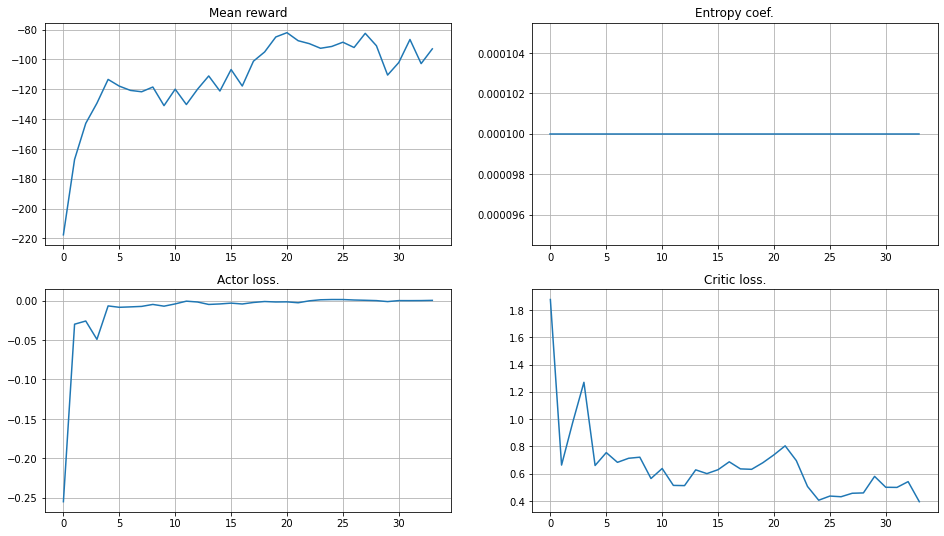

KeyboardInterrupt: 

In [131]:
for i in range(100):
    entropy_coef = 1e-4
    entropy_coefs.append(entropy_coef)
    rewards, ac_loss, cr_loss = zip(*[train_on_session(*generate_session(env, 10000), entropy_coef=entropy_coef)
                                 for _ in range(100)])

    mean_reward.append(np.mean(rewards))
    actor_loss.append(np.mean(ac_loss))
    critic_loss.append(np.mean(cr_loss))
    
    clear_output(True)

    print(f"mean reward: {mean_reward[-1]:.1f}")

    plt.figure(figsize=[16, 9])
    plt.subplot(2, 2, 1)
    plt.title("Mean reward")
    plt.plot(mean_reward)
    plt.grid()

    plt.subplot(2, 2, 2)
    plt.title("Entropy coef.")
    plt.plot(entropy_coefs)
    plt.grid()
    
    plt.subplot(2, 2, 3)
    plt.title("Actor loss.")
    plt.plot(actor_loss)
    plt.grid()
    
    plt.subplot(2, 2, 4)
    plt.title("Critic loss.")
    plt.plot(critic_loss)
    plt.grid()

    plt.show()

    if mean_reward[-1] > 500:
        print("You Win!")
        break

In [132]:
# Record sessions
import gym.wrappers


with gym.wrappers.Monitor(gym.make("Acrobot-v1"), directory="videos", force=True) as env_monitor:
    sessions = [generate_session(env_monitor, 100000) for _ in range(100)]

## Fuck the world